In [3]:
from preprocess import *
from outlier_detection import *


preprocessor = Preprocess(override=True)

{0: 'NL', 1: 'PE', 2: 'NS', 3: 'NB', 4: 'QC', 5: 'ON', 6: 'MB', 7: 'SK', 8: 'AB', 9: 'BC', 10: 'YT', 11: 'NT', 12: 'NU'}
Model fitted


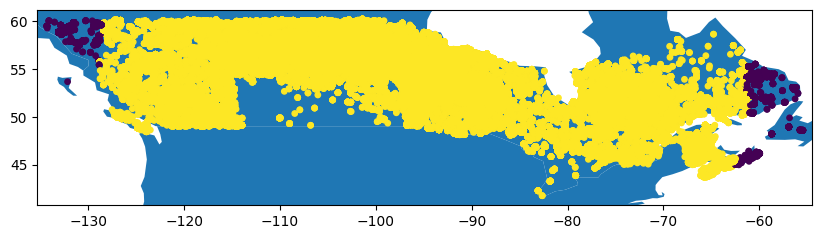

Model fitted


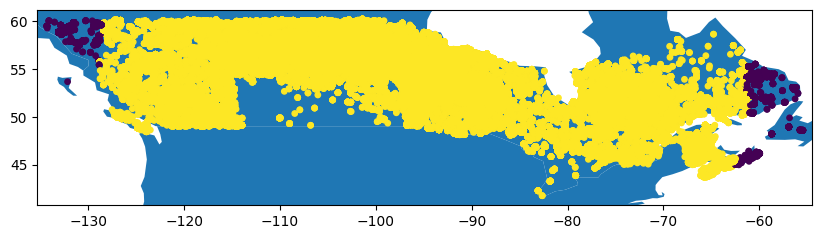

In [5]:
import pickle
from preprocess import *
from outlier_detection import *
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


def outlier_detection(preprocessor: Preprocess):
    
    # Load the fire data
    df = preprocessor.get_fire_data()
    df = df[[
        # 'HectaresBurnt', 
        # 'AverageTemperature', 
        'FireLatitude', 
        'FireLongitude', 
        'ProvinceID'
        ]]
    
    print(preprocessor.province_mapping)
    
    for nu in [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]:
        for province in df['ProvinceID'].unique():
            os.makedirs(f'./images/oneclass_svm/{nu}', exist_ok=True)
            
            fire_data = df.copy()[df['ProvinceID'] == province]
            # fire_data = df.copy()
            model = OutlierDetection(fire_data, OneClassSVM(nu=nu))
            fire_data = model.detect()
            
            geometry = fire_data.apply(lambda x: Point(x["FireLongitude"], x["FireLatitude"]), axis=1)
            world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
            ax = world.plot(figsize=(10, 6))
            ax.set_xlim([fire_data['FireLongitude'].min() - 1, fire_data['FireLongitude'].max() + 1])
            ax.set_ylim([fire_data['FireLatitude'].min() - 1, fire_data['FireLatitude'].max() + 1])
            gdf = GeoDataFrame(fire_data, geometry=geometry)   
            gdf.plot(column='anomaly', ax=ax, marker='o', markersize=15, )
            plt.savefig(f'./images/oneclass_svm/{nu}/{preprocessor.province_mapping[province]}.png')
            plt.show()
            plt.close()


outlier_detection(preprocessor)